<a href="https://colab.research.google.com/github/whtan88/RandomDataAnalyst_DataAnalysis/blob/main/From_Mystery_to_Clarity_Using_SHAP_to_Explain_ML_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration of SHAP values

The objective of this notebook is to explore the usage of SHAP values in machine learning model explainability. We will be using the Spaceship Titanic Dataset from Kaggle for this purpose.

We will do the following:


*  Preprocess the dataset
*  Train several supervised classification machine learning models
*  Use SHAP to uncover the explanation of the classifications made by the machine learning models
*  Explore how do we use SHAP for unsupervised machine learning models



## Download Dataset

Below is a set of code which is used to connect via Kaggle API to download the dataset to be used.

Reference can be found from discussion thread here: https://www.kaggle.com/discussions/general/74235

In [ ]:
# Accessing Kaggle API to download the dataset

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

dataset = 'spaceship-titanic'
!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 34.6MB/s]


In [ ]:
# Import necessary libraries
!pip install skrub

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from skrub import TableReport
from sklearn.metrics import accuracy_score
import shap
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import tensorflow as tf
from sklearn.cluster import KMeans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.6/327.6 kB 4.1 MB/s eta 0:00:00


We will be using a library which I recently discovered to perform simple EDA on the data to familiarise ourselves with it. The library is called skrub, and it provides a neat table report form of the loaded data that you can use to inspect the data easily. Try it out below for yourself.

In [ ]:
# Load and read the training data
df = pd.read_csv("/content/spaceship-titanic/train.csv")
TableReport(df)

<TableReport: use .open() to display>

## Preprocessing the Data

We will be doing the following simple preprocessing of the Spaceship Titanic dataset here.

* String splitting the passenger and cabin columns
* Filling up NA values for columns
* Setting true false variables to binary
* Dropping some unused columns

In [ ]:
# String Splitting Passenger and Cabin columns
df['PassengerId1'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype('int64')
df['Cabin1'] = df['Cabin'].str.split('/').str[0]
df['Cabin2'] = df['Cabin'].str.split('/').str[1]
df['Cabin3'] = df['Cabin'].str.split('/').str[2]

# Filling NA values of the remaining columns with an appropriate value
df['Cabin1'].fillna('F', inplace = True)
df['Cabin3'].fillna('S', inplace = True)
df['HomePlanet'].fillna('Earth', inplace = True)
df['CryoSleep'].fillna(False, inplace = True)
df['Destination'].fillna('TRAPPIST-1e', inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['VIP'].fillna(False, inplace = True)

Amenity_list = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for i in Amenity_list:
  df[i].fillna(0, inplace = True)

# Setting binary variables
df.replace({False:0, True:1}, inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(bool)
df['VIP'] = df['VIP'].astype(bool)
df['Transported'] = df['Transported'].astype(bool)

# Setting the target variable
y = df['Transported']

# Output of table x after initial preprocessing
x = df.drop(['PassengerId','Name','Transported','Cabin','Cabin2'], axis=1)
TableReport(x)

<ipython-input-4-efd0db642e81>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin1'].fillna('F', inplace = True)
<ipython-input-4-efd0db642e81>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

<TableReport: use .open() to display>

Next, we will do additional preprocessing such as 1 hot encoding and scaling to ensure that the data is in a readable format for machine learning models.

In [ ]:
# Performing 1 hot encoding for object fields
x = pd.get_dummies(x, columns=['HomePlanet','Destination','Cabin1','Cabin3'], drop_first=True, dtype=bool)

# Scaling the cardinal data
scaled_column_list = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i in scaled_column_list:
  x[[i]] = sklearn.preprocessing.StandardScaler().fit_transform(x[[i]])


TableReport(x)

<TableReport: use .open() to display>

## Training an XGB Classifier and inspecting the SHAP values

In this section, we will train an XGB Classifier and inspect the SHAP values in the various plots below.

After we train the model, we have to fit the model into the explainer object, in order for the features to be revealed.

Then, we can plot the SHAP values using the various plots below to visualise different views of the features.

In [ ]:
# Training XGB classifier
y.astype("bool")

model_xgb = xgb.XGBClassifier(enable_categorical=True).fit(x,y)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(x)

We can plot the below bar summary plot to view the mean SHAP value of each feature on the model output, starting from the feature with the most impact in descending order. Note that the value here is just the mean absolute value, and it can influence the model output in both directions.

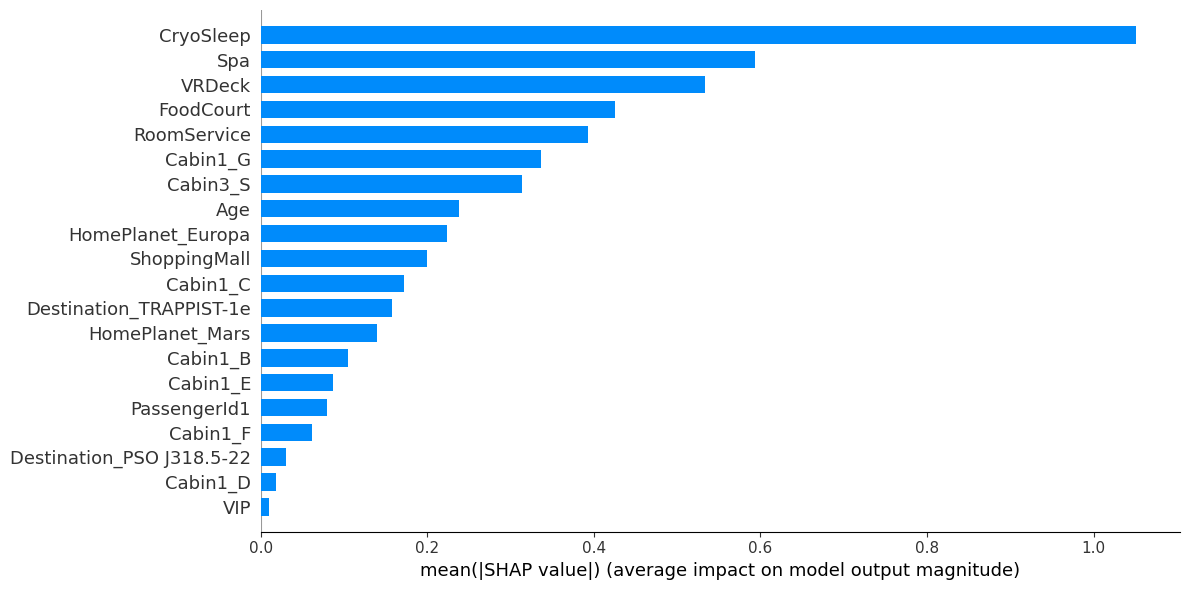

In [ ]:
# Display the mean SHAP values of the variables
shap.summary_plot(shap_values, plot_type='bar', plot_size=[12,6])

We can plot the beeswarm plot below to inspect the impact of the variables. Red colour means that it has a high feature value on the model output and blue means that it has a low feature value instead.

In this case, we see that for passengers who do have CryoSleep (ie CryoSleep = True) are more likely to be transported compared to passengers who do not.

Another example is that for the feature Cabin1_G, for passengers staying in Cabins starting with the letter G, they are more likely to be not transported compared to passengers who do not stay in Cabins starting with the letter G.

An interesting observation here is that for the feature Cabin3_S, it is extracted from cabins on starboard versus port side. It seems that passengers who are staying in cabins on the starboard side are more likely to be transported as well.

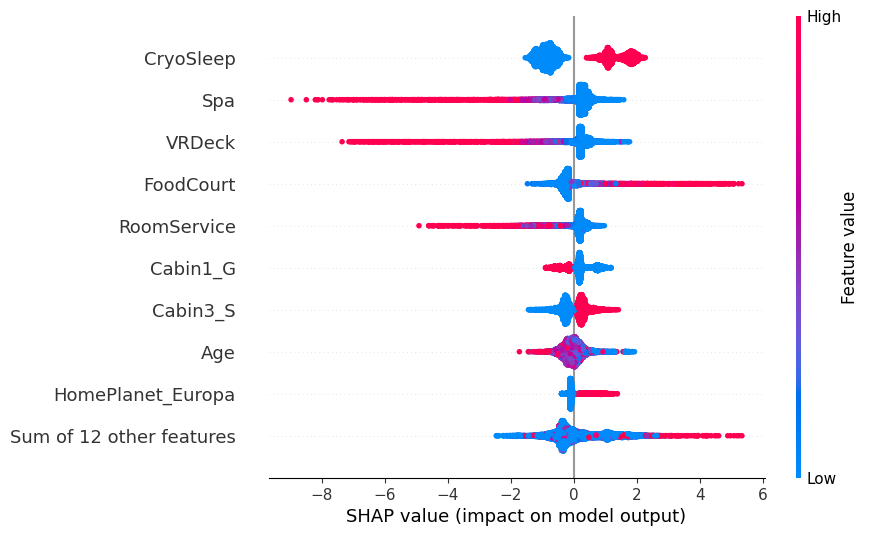

In [ ]:
# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values, plot_size=[8,6])

Next, we can also plot a waterfall plot to view the feature contribution to the final value for an individual data point. It starts off with an expected value, with each feature making contributions, either to add or to subtract from the expected value, which after all the feature values have been aggregated, a final value will be given, which will help explain the decision the model made.

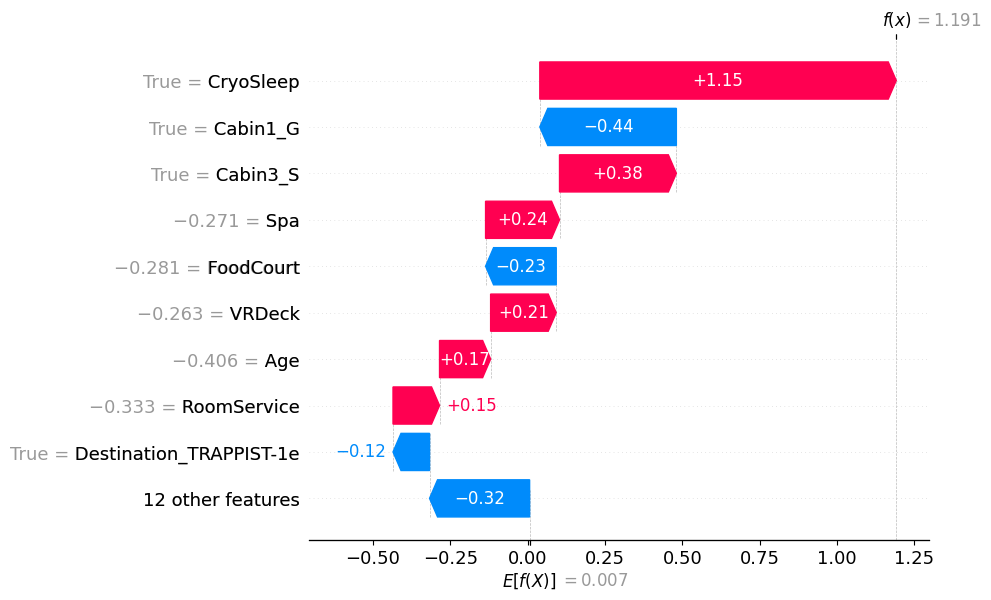

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
shap.plots.waterfall(shap_values[100], max_display=10)

Apart from the waterfall plot, we can also visualise in another way using a force plot for a single data prediction how the features work together to give the end score.

In [ ]:
# Displaying the forceplot for explanations of a prediction
shap.initjs()
shap.force_plot(shap_values[100])

We will now take a closer look at the SHAP values. For a selected row, we can see that the actual result is false and the model actually predicted 1 (ie true), which is an incorrect prediction.

Looking at the model's predicted probability, the values are 0.23 and 0.77 for 0 and 1 respectively. This means the model predicted 1 with a probability of 77%.

The average expected and incremental SHAP values of 0.007 and 1.18 corresponds with what we see previously and results in an agregated SHAP value of 1.19. This is actually the lognormal probability of the prediction and if we convert it to normal probability, we will get a value of 0.23 which approximates to the probability of the predicted value being 0.

In [ ]:
# Assessing model accuracy
y_pred = model_xgb.predict(x)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculation of the expected SHAP value
pred = 100
print(f"Actual Result: {y[pred]}")
print(f"Predicted Result: {model_xgb.predict(x.iloc[[pred]])}")
print(f"Predicted Probability: {model_xgb.predict_proba(x.iloc[[pred]])}")
print(f"Average expected SHAP value : {shap_values.base_values[pred]}")
print(f"Incremental SHAP value from contributing variables : {sum(shap_values.values[pred])}")
print(f"Final expected SHAP value for prediction: {shap_values.base_values[pred]+sum(shap_values.values[pred])}")
print(f"Converted Prediction Probability: {(1 / (1 + np.exp(-shap_values.base_values[pred]+sum(shap_values.values[pred]))))}")

Accuracy: 89.06%
Actual Result: False
Predicted Result: [1]
Predicted Probability: [[0.23299694 0.76700306]]
Average expected SHAP value : 0.0066872816532850266
Incremental SHAP value from contributing variables : 1.1847775564529002
Final expected SHAP value for prediction: 1.1914648381061852
Converted Prediction Probability: 0.23539574363242008


## Training a Random Forest Classifier

We will also train a Random Forest Classifier here and plot similar plots to the XGB above. You can see and compare if there are any differences to the feature contributions.

In [ ]:
# Training a Random Forest Classifier
y.astype("bool")
model_rf = RandomForestClassifier(n_estimators=100, max_depth=2).fit(x,y)
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer(x)
print(shap_values.shape)

(8693, 21, 2)


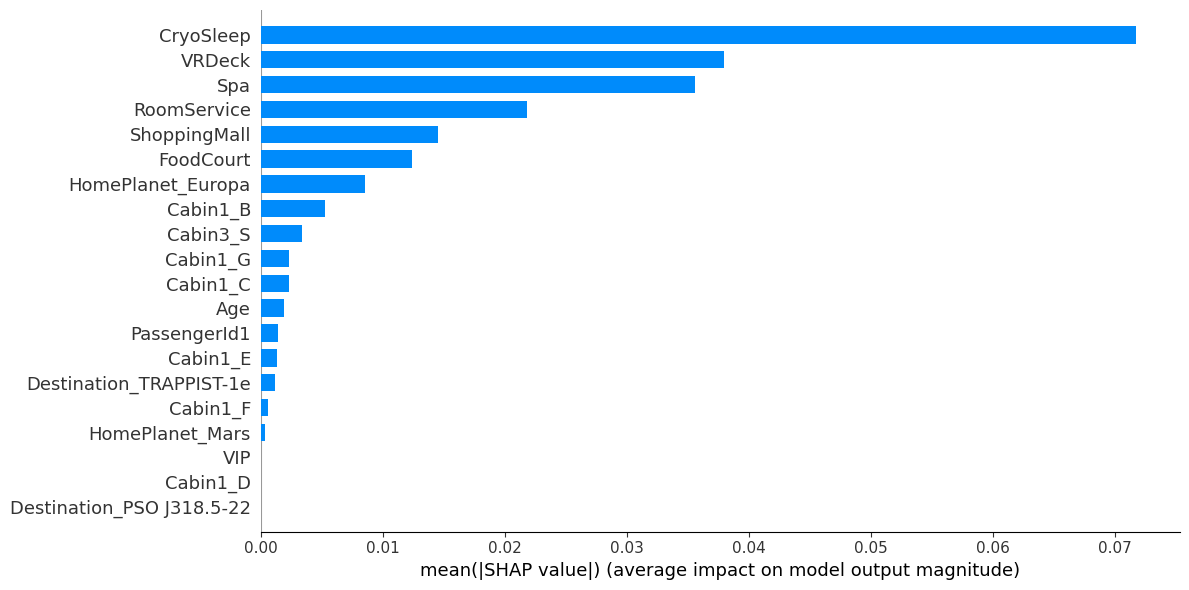

In [ ]:
# Display the mean SHAP values of the variables
shap.summary_plot(shap_values[: ,: ,0], x, plot_type='bar', plot_size=[12,6])

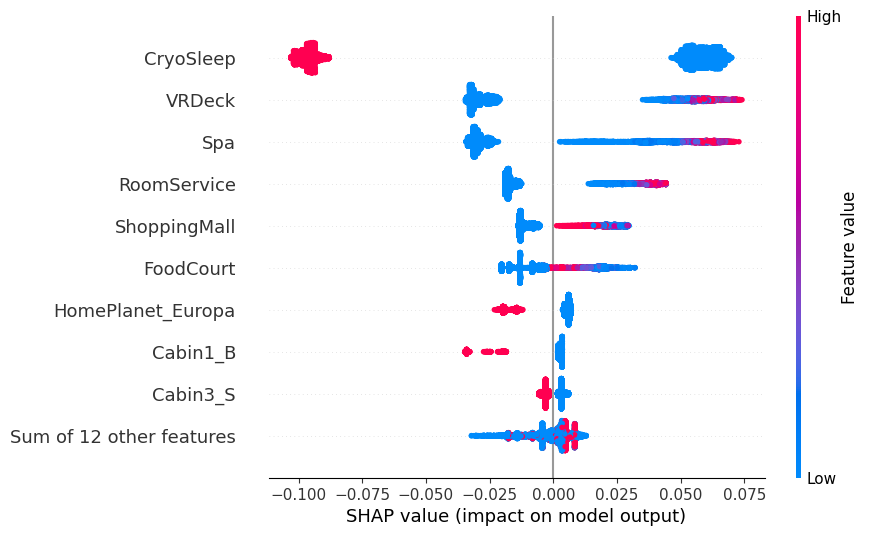

In [ ]:
# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values[: ,: ,0], plot_size=[8,6])

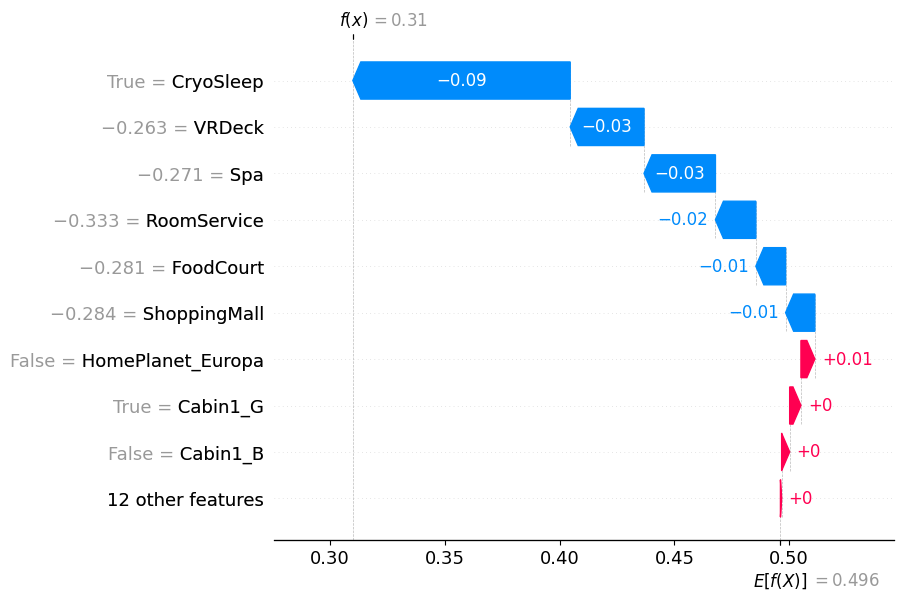

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
shap.plots.waterfall(shap_values[100, :, 0], max_display=10)

Similarly, we can inspect the SHAP values for the random forest classifier and this time, we can see that the numbers mean differently. For the random forest classifier, the predicted SHAP values are the same as the predicted probability for each label.

In [ ]:
# Assessing model accuracy
y_pred = model_rf.predict(x)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculation of the expected SHAP value
pred = 100
print(f"Actual Result: {y[pred]}")
print(f"Predicted Result: {model_rf.predict(x.iloc[[pred]])}")
print(f"Predicted Probability: {model_rf.predict_proba(x.iloc[[pred]])}")
print(f"Average expected SHAP value : {shap_values.base_values[pred]}")
print(f"Incremental SHAP value from contributing variables : {sum(shap_values.values[pred])}")
print(f"Final expected SHAP value for prediction: {shap_values.base_values[pred]+sum(shap_values.values[pred])}")

Accuracy: 73.93%
Actual Result: False
Predicted Result: [ True]
Predicted Probability: [[0.31379705 0.68620295]]
Average expected SHAP value : [0.49667203 0.50332797]
Incremental SHAP value from contributing variables : [-0.18287498  0.18287498]
Final expected SHAP value for prediction: [0.31379705 0.68620295]


## Training a Support Vector Machine

Similarly, we will also train a Support Vector Machine here and plot similar plots to the machine learning models above. You can see and compare if there are any differences to the feature contributions.

In [ ]:
# Training a SVM
model_svm = svm.SVC(probability=True).fit(x.iloc[:200, :],y[:200])
explainer = shap.KernelExplainer(model_svm.predict,shap.sample(x.iloc[:200, :], 5))
shap_values = explainer(x.iloc[:200, :])

  0%|          | 0/200 [00:00<?, ?it/s]

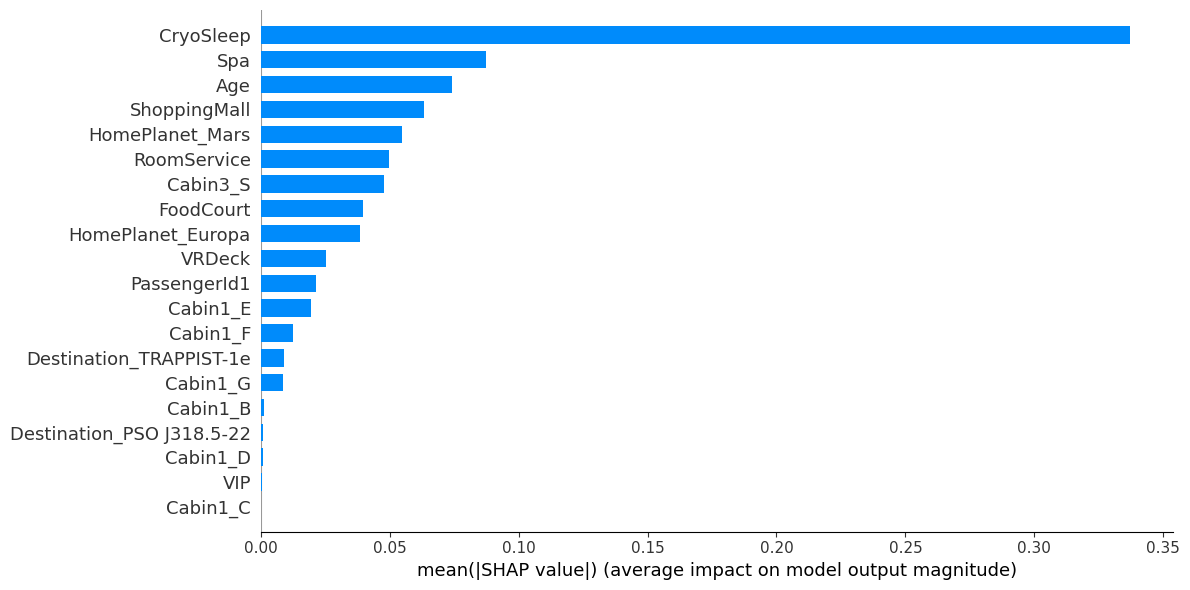

In [ ]:
# Display the mean SHAP values of the variables
shap.summary_plot(shap_values, plot_type='bar', plot_size=[12,6])

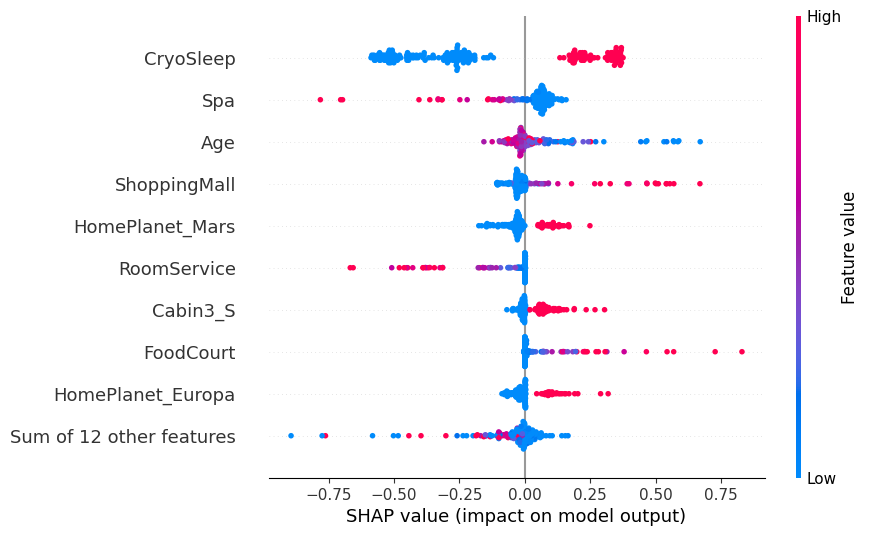

In [ ]:
# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values, plot_size=[8,6])

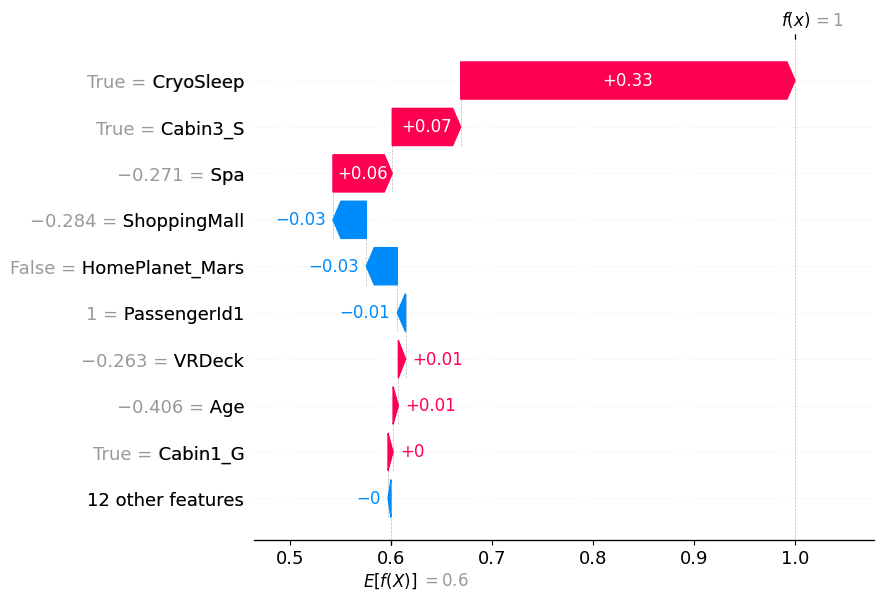

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
shap.plots.waterfall(shap_values[100], max_display=10)

For the support vector machine, the SHAP value is binary instead. It is either 0 or 1.

In [ ]:
# Assessing model accuracy
y_pred = model_svm.predict(x)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculation of the expected SHAP value
pred = 100
print(f"Actual Result: {y[pred]}")
print(f"Predicted Result: {model_svm.predict(x.iloc[[pred]])}")
print(f"Predicted Probability: {model_svm.predict_proba(x.iloc[[pred]])}")
print(f"Average expected SHAP value : {shap_values.base_values[pred]}")
print(f"Incremental SHAP value from contributing variables : {sum(shap_values.values[pred])}")
print(f"Final expected SHAP value for prediction: {shap_values.base_values[pred]+sum(shap_values.values[pred])}")

Accuracy: 77.20%
Actual Result: False
Predicted Result: [ True]
Predicted Probability: [[0.20349337 0.79650663]]
Average expected SHAP value : 0.6000000000000001
Incremental SHAP value from contributing variables : 0.3999999999999999
Final expected SHAP value for prediction: 1.0


## Training a Neural Network Model

We will rinse and repeat here and train a Neural Network Model here and plot similar plots to the machine learning models above. You can see and compare if there are any differences to the feature contributions.

In [ ]:
# Creating and training a Neural Network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

model_NN = model.fit(x = x, y = y,verbose=1,epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7250 - loss: 0.5416
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8014 - loss: 0.4259
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8027 - loss: 0.4109
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8018 - loss: 0.4092
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8046 - loss: 0.3994
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8059 - loss: 0.4058
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8041 - loss: 0.3978
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8089 - loss: 0.3984
Epoch 9/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8055 - loss: 0.3952
Epoch 10/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7988 - loss: 0.3979


In [ ]:
# Converting the data inputs into a readable format by the Neural Network
x_numeric = x.astype(int)
explainer = shap.KernelExplainer(lambda x: model.predict(x), shap.sample(x_numeric.iloc[:200, :],5))
shap_values = explainer(x_numeric.iloc[:200, :])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
160/160 ━━━━━━━━━━━━━━━

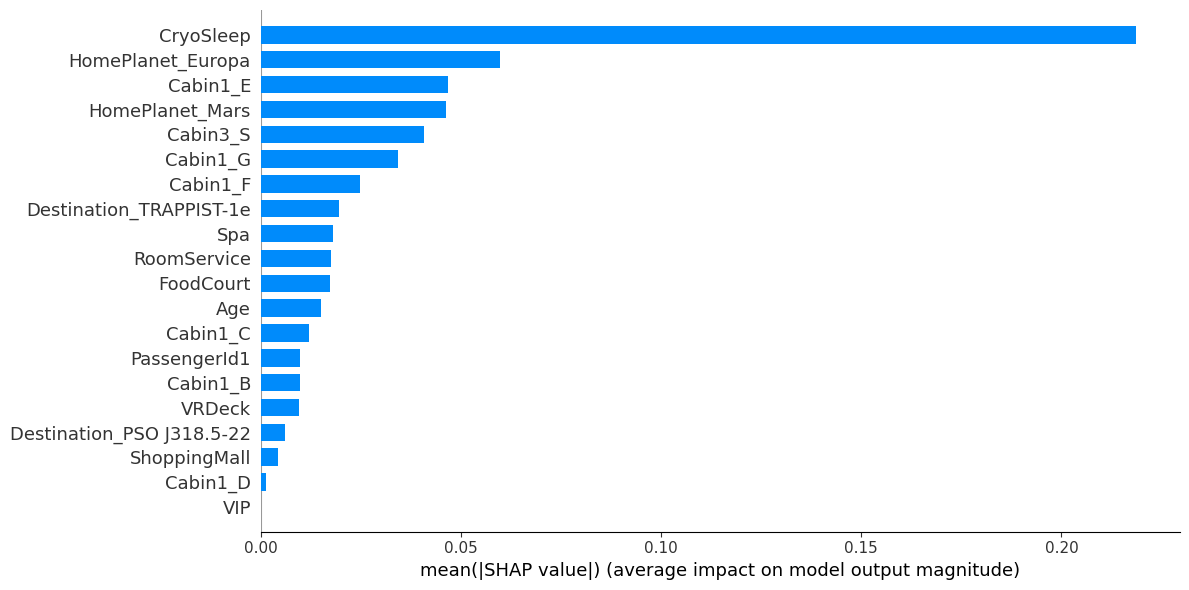

In [ ]:
# Display the mean SHAP values of the variables
shap.summary_plot(shap_values[:, :, 0], plot_type='bar', plot_size=[12,6])

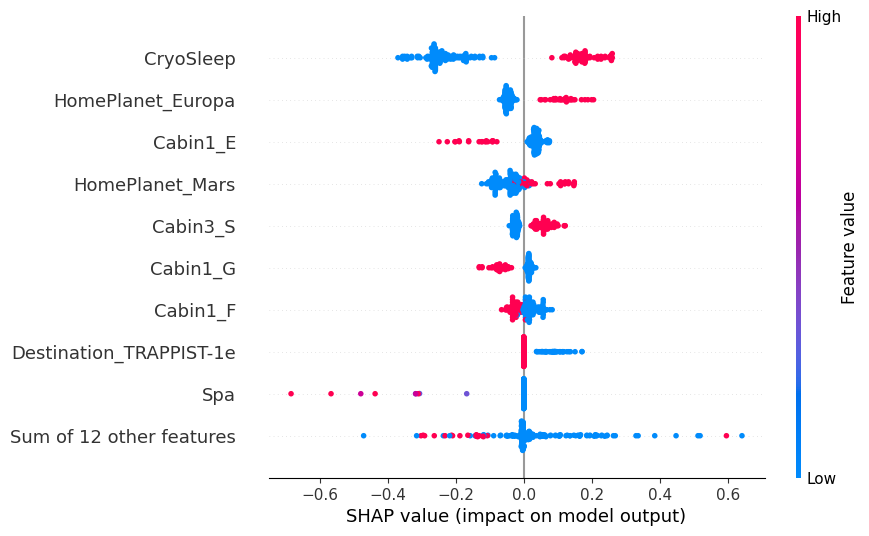

In [ ]:
# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values[:, :, 0], plot_size=[8,6])

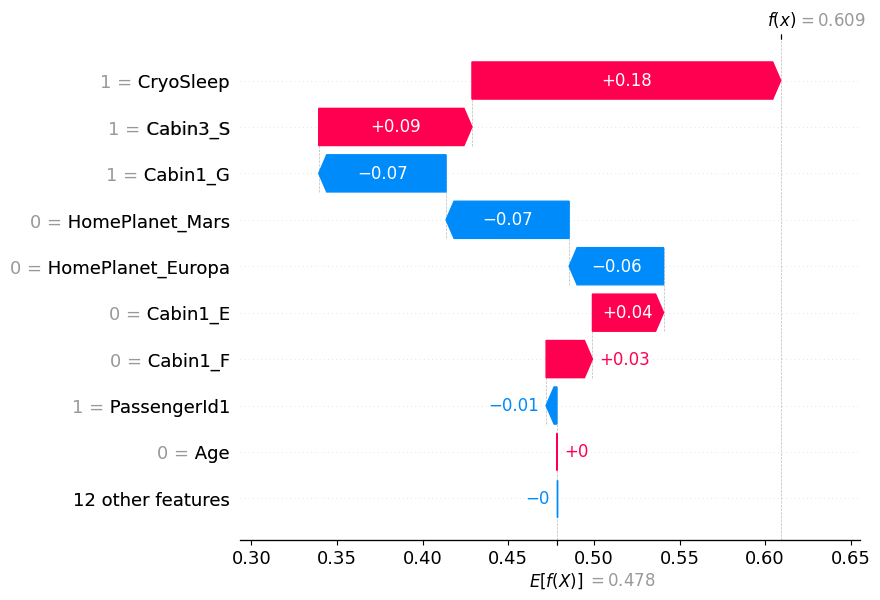

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
shap.plots.waterfall(shap_values[100, :, 0], max_display=10)

For the neural network, I believe that the value is actually the estimated probability of the prediction. If it is greater than 0.5, it means the model will predict it to be 1. If it is lesser, the model predicts it to be 0 instead.

In [ ]:
# Assessing model accuracy
y_pred = model.predict(x)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y, y_pred_binary)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculation of the expected SHAP value
pred = 100
print(f"Actual Result: {y[pred]}")
print(f"Predicted Result: {(model.predict(x.iloc[[pred]]) > 0.5).astype(int)}")
print(f"Average expected SHAP value : {shap_values.base_values[pred]}")
print(f"Incremental SHAP value from contributing variables : {sum(shap_values.values[pred])}")
print(f"Final expected SHAP value for prediction: {shap_values.base_values[pred]+sum(shap_values.values[pred])}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 81.58%
Actual Result: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Result: [[1]]
Average expected SHAP value : [0.41342426]
Incremental SHAP value from contributing variables : [0.10519051]
Final expected SHAP value for prediction: [0.51861477]


## Training a K Means Clustering Unsupervised Model

Now, we will try something different and train an unsupervised machine learning model. Let's train a K Means Clustering Model here and plot similar plots to the machine learning models above. Let's see how it will turn out!

In [ ]:
# Training an unsupervised Machine Learning Model
model_kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
explainer = shap.KernelExplainer(model_kmeans.predict, shap.sample(x.iloc[:500, :], 5))
shap_values = explainer(x.iloc[:500, :])

  0%|          | 0/1000 [00:00<?, ?it/s]

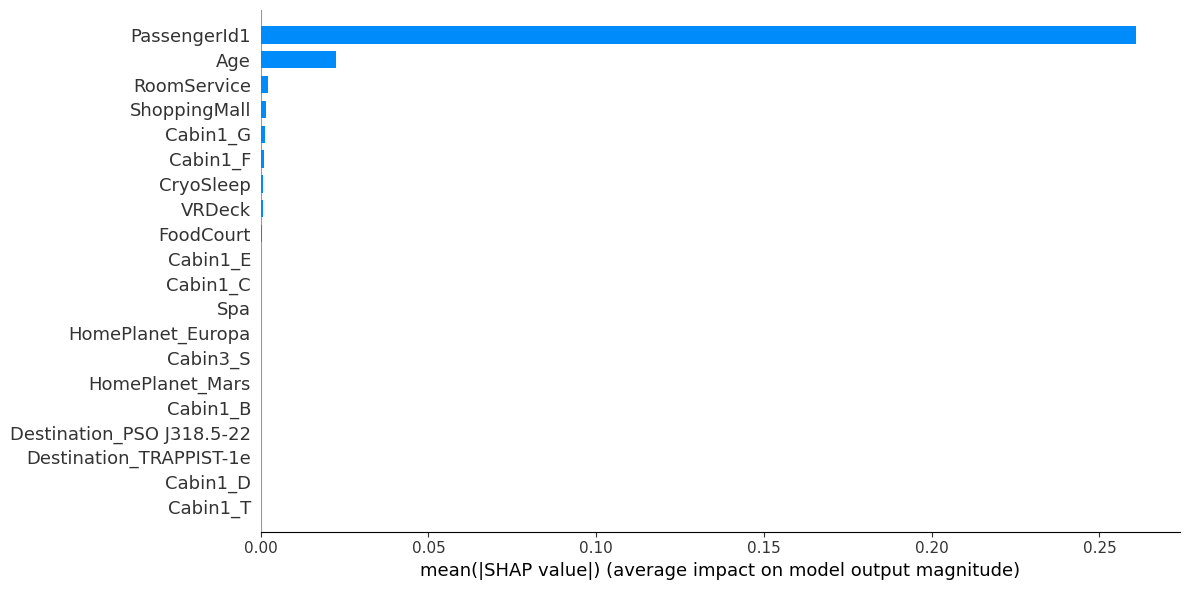

In [ ]:
# Display the mean SHAP values of the variables
shap.summary_plot(shap_values, plot_type='bar', plot_size=[12,6])

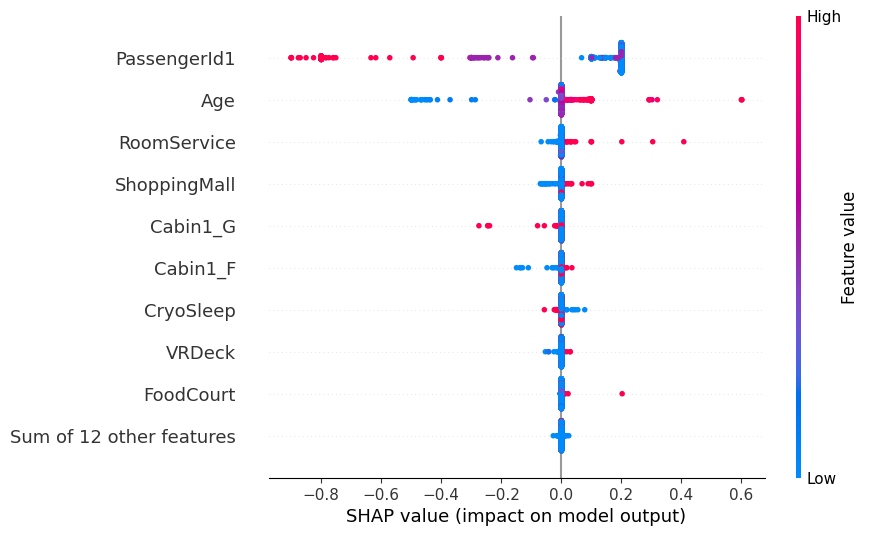

In [ ]:
# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values, plot_size=[8,6])

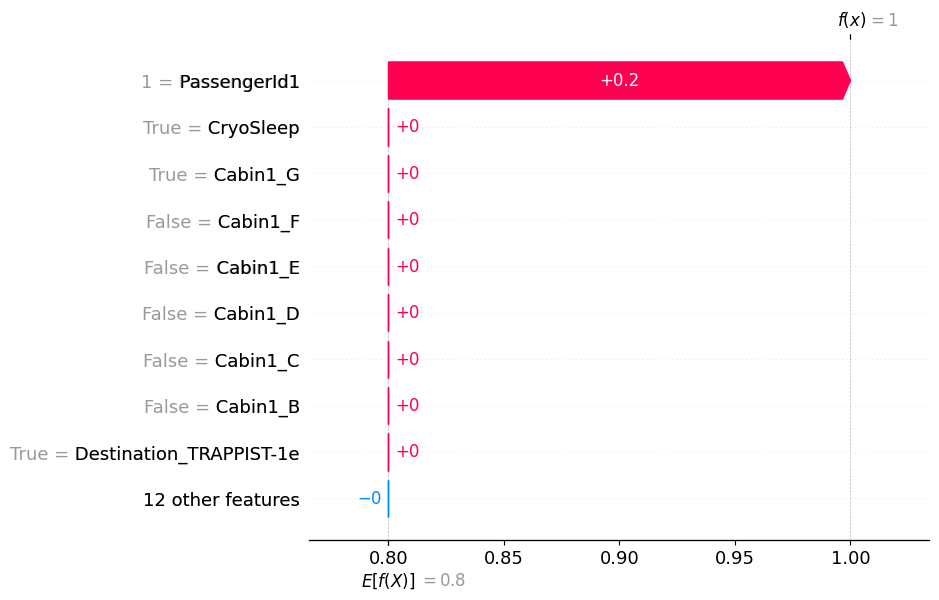

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
shap.plots.waterfall(shap_values[100], max_display=10)

In [ ]:
# Assessing model accuracy
y_pred = model_kmeans.predict(x)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculation of the expected SHAP value
pred = 100
print(f"Actual Result: {y[pred]}")
print(f"Predicted Result: {model_kmeans.predict(x.iloc[[pred]])}")
print(f"Average expected SHAP value : {shap_values.base_values[pred]}")
print(f"Incremental SHAP value from contributing variables : {sum(shap_values.values[pred])}")
print(f"Final expected SHAP value for prediction: {shap_values.base_values[pred]+sum(shap_values.values[pred])}")

Accuracy: 47.19%
Actual Result: False
Predicted Result: [1]
Average expected SHAP value : 0.8
Incremental SHAP value from contributing variables : 0.19999999999999996
Final expected SHAP value for prediction: 1.0


We can see that the results for the unsupervised machine learning model turned out very differently and it came out with different features. We can't expect it to perform too well but this shows that you can apply SHAP to decoding unsupervised machine learning models too, and allow features to be decomposed and compartmentalised too.